In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/fix/feature_selected_reg_full.csv')


=== Evaluation on Test ===
recession_probability: MAE=2.3824, RMSE=8.7048, R2=0.7449
1_month_recession_probability: MAE=3.8526, RMSE=15.1788, R2=0.2242
3_month_recession_probability: MAE=5.4455, RMSE=20.7140, R2=-1.8451
6_month_recession_probability: MAE=22.5390, RMSE=33.8163, R2=-4905.1777


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/l

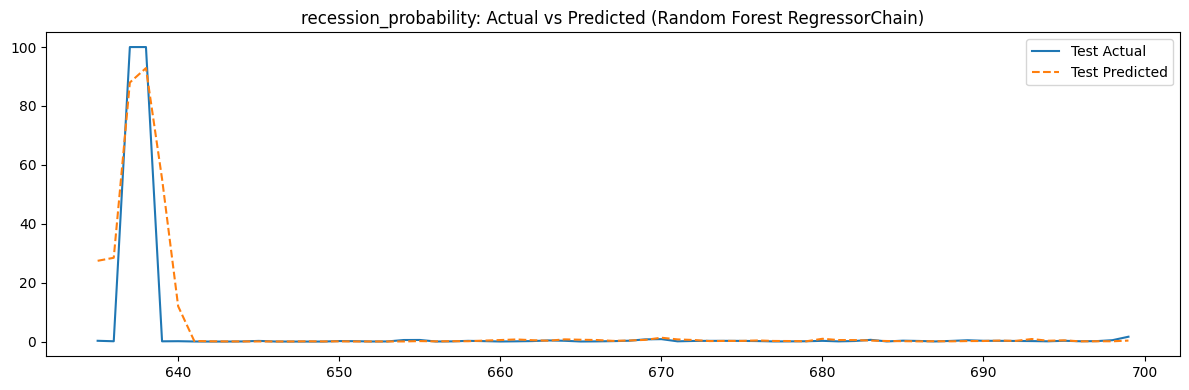

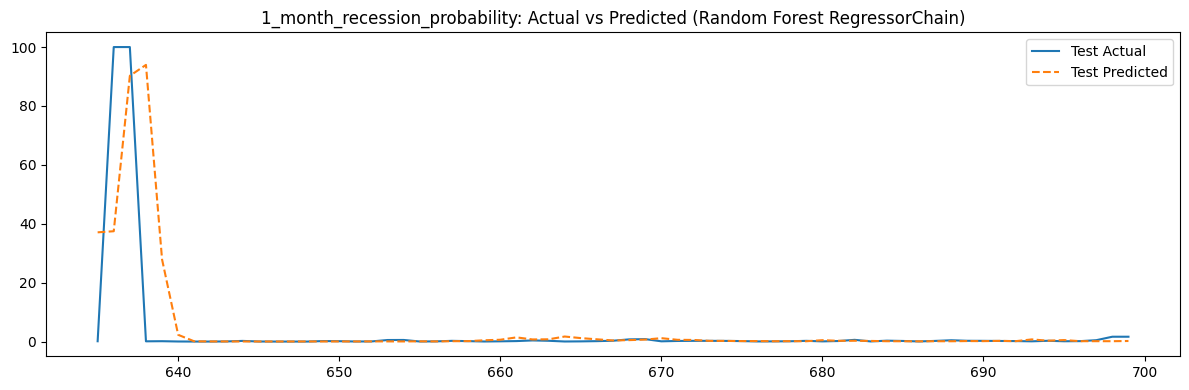

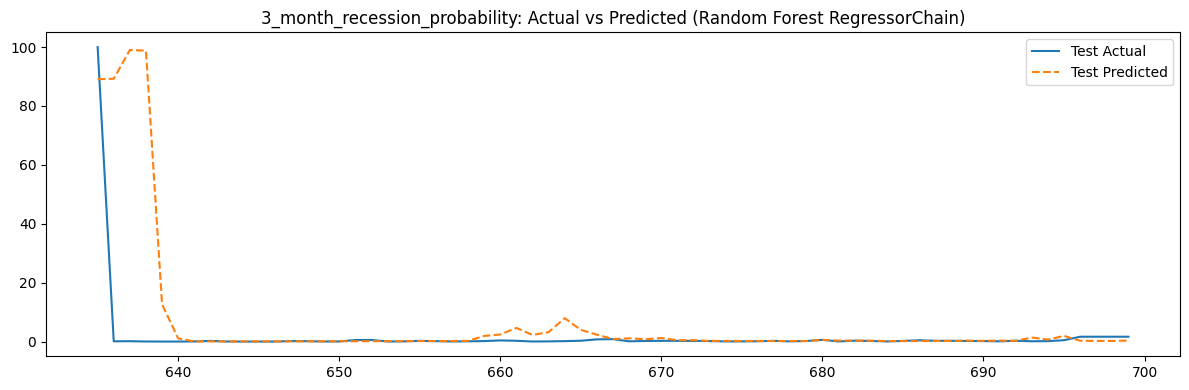

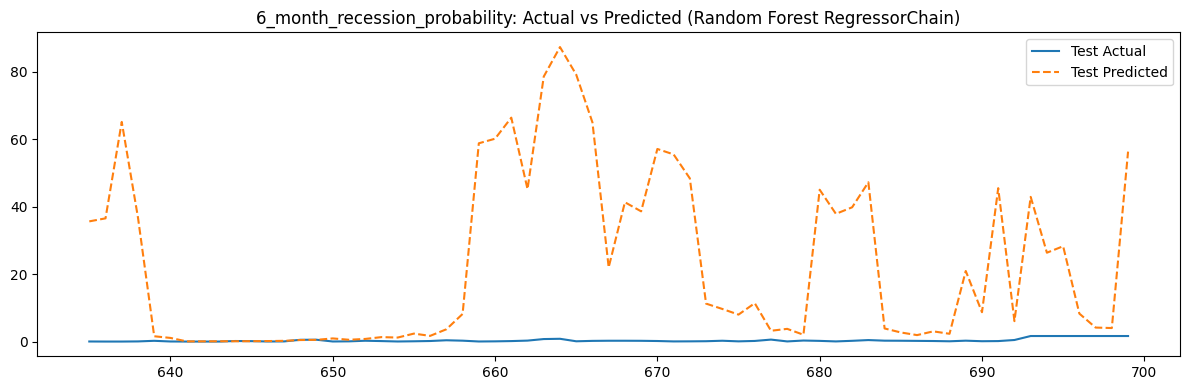

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -------------------------
# Targets
# -------------------------
recession_targets = [
    "recession_probability",
    "1_month_recession_probability",
    "3_month_recession_probability",
    "6_month_recession_probability",
]

# -------------------------
# Split train/test
# -------------------------
split_date = "2020-01-01"
df["date"] = pd.to_datetime(df["date"])
train_df = df[df["date"] < split_date].copy()
test_df  = df[df["date"] >= split_date].copy()

X_train = train_df.drop(columns=recession_targets + ["date"])
X_test  = test_df.drop(columns=recession_targets + ["date"])
y_train = train_df[recession_targets]
y_test  = test_df[recession_targets]

# -------------------------
# Clean NaNs
# -------------------------
def clean_data(X_or_y):
    X_or_y = X_or_y.replace([np.inf, -np.inf], np.nan)
    X_or_y = X_or_y.ffill().bfill()
    X_or_y = X_or_y.fillna(0)
    return X_or_y

X_train = clean_data(X_train)
X_test  = clean_data(X_test)
y_train = clean_data(y_train)
y_test  = clean_data(y_test)

# -------------------------
# Logit transform
# -------------------------
epsilon = 1e-6
def logit_transform(y):
    y_scaled = np.clip(y / 100, epsilon, 1 - epsilon)
    return np.log(y_scaled / (1 - y_scaled))

def inv_logit_transform(y_logit):
    y_prob = 1 / (1 + np.exp(-y_logit))
    return y_prob * 100

# -------------------------
# Step 1: RegressorChain for first 3 targets
# -------------------------
chain_targets = recession_targets[:3]
y_train_chain = logit_transform(y_train[chain_targets].values)

rf_base = RandomForestRegressor(
    n_estimators=500,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

chain_model = RegressorChain(base_estimator=rf_base, order=None)
chain_model.fit(X_train, y_train_chain)

preds_chain_logit = chain_model.predict(X_test)
preds_chain_df = pd.DataFrame(
    inv_logit_transform(preds_chain_logit),
    columns=chain_targets,
    index=X_test.index
).clip(0, 100)

# -------------------------
# Step 2: Separate model for 6-month target
# -------------------------
target_6m = "6_month_recession_probability"

# Add chain predictions as features for 6-month model
X_train_6m = X_train.copy()
X_train_6m[chain_targets] = inv_logit_transform(chain_model.predict(X_train))

X_test_6m = X_test.copy()
X_test_6m[chain_targets] = preds_chain_df

y_train_6m = logit_transform(y_train[target_6m].values)

rf_6m = RandomForestRegressor(
    n_estimators=500,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf_6m.fit(X_train_6m, y_train_6m)
pred_6m = inv_logit_transform(rf_6m.predict(X_test_6m)).clip(0, 100)

# -------------------------
# Combine all predictions
# -------------------------
preds_test_final = preds_chain_df.copy()
preds_test_final[target_6m] = pred_6m

# -------------------------
# Evaluation
# -------------------------
def evaluate(y_true, y_pred, dataset_name="Dataset"):
    print(f"\n=== Evaluation on {dataset_name} ===")
    for target in recession_targets:
        mae = mean_absolute_error(y_true[target], y_pred[target])
        rmse = mean_squared_error(y_true[target], y_pred[target], squared=False)
        r2 = r2_score(y_true[target], y_pred[target])
        print(f"{target}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

evaluate(y_test, preds_test_final, "Test")

# -------------------------
# Plot Actual vs Predicted
# -------------------------
for target in recession_targets:
    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, y_test[target], label="Test Actual")
    plt.plot(preds_test_final[target], label="Test Predicted", linestyle="--")
    plt.title(f"{target}: Actual vs Predicted (Random Forest RegressorChain)")
    plt.legend()
    plt.tight_layout()
    plt.show()
